# **(Re-)Imag(in)ing Price Trends Paper**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Dense, Flatten, GlobalMaxPool2D

In [3]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

%run ../sys_configs.ipynb

Mounted at /content/drive


In [4]:
with open('../data/1s_train.npy', 'rb') as f:
    x1s_train = np.load(f)
    y1s_train = np.load(f)
sz, dim = x1s_train.shape[1:]

with open('../data/1s_val.npy', 'rb') as f:
    x1s_val = np.load(f)
    y1s_val = np.load(f)

In the paper [1], Jiang et al. approach their problem instance of stock market return prediction using an imagistic representation of a time series and running a CNN over this image. The input is the plot of past market prices which are represented as a matrix of black and white pixels, where the location along the x-axis corresponds to the time and the location along the y-axis corresponds to the price level.

Black is used as the background colour and white is used to denote where the price level is. This eases the data storage requirements; a black pixel can be represented by (0,0,0) while white pixels are represented by (255,255,255).

In the GAR problem instance, there are 6 channels, so we set up 6 greyscale images.

The paper introduces basic CNN architectures. We run these architectures over the train and validation sets using window technique 1, as the architectures use (local) max pooling.

## **Transform data to images**

In [5]:
h = 50 # Number of discrete blocks in which to divide the level of the time series up
w = 500 # Length of the time series

N_train = len(x1s_train) # Number of elements in the train dataset
N_val = len(x1s_val) # Number of elements in the validation dataset

In [6]:
# The data are already normalised to have mean 0 and std 1, so we map each value to be between 0 and 1 using the CDF function
train = scipy.stats.norm.cdf(x1s_train)
val = scipy.stats.norm.cdf(x1s_val)

# Map the data to be between 0 and h (the value denotes the row index which will be populated)
train_idxs = np.floor(train * h).astype(int)
val_idxs = np.floor(val * h).astype(int)

# Whilst this line should be redundant, the data is clipped to account for any anomalies outside the range (0, h - 1)
train_idxs = np.clip(train_idxs, 0, h - 1)
val_idxs = np.clip(val_idxs, 0, h - 1)

In [7]:
# Transpose the images so the height dimension comes second (rather than fourth)
train_images = np.eye(h)[train_idxs].transpose((0, 3, 1, 2))
val_images = np.eye(h)[val_idxs].transpose((0, 3, 1, 2))

In [8]:
print("The train data shape is {} and the validation data shape is {}".format(train_idxs.shape, val_idxs.shape))

The train data shape is (3033, 500, 6) and the validation data shape is (992, 500, 6)


#### **Explanation of Indexing in `np.eye(num_bins)[discretized_indices]`**

1. **Creating an Identity Matrix:**
   - `np.eye(h)` creates an identity matrix of size `h x h`.

2. **Generating Discretised Indices:**
   - `train_idxs` and `val_idxs` are 3D arrays where each element represents an index in the range `[0, h-1]`. These elements were derived by mapping the initial normalised values through the CDF function and scaling to `[0, h-1]`.

3. **Advanced Indexing with the Identity Matrix:**
   - `np.eye(h)[train_idxs]` uses the values in `train_idxs` to select rows from the identity matrix.
   - For each element in `train_idxs`, the corresponding row from the identity matrix is taken.

In [9]:
# Convert the labels to tensors
train_labels_tf = tf.convert_to_tensor(y1s_train, dtype = tf.int32)
val_labels_tf = tf.convert_to_tensor(y1s_val, dtype = tf.int32)

### **Input 1: Greyscale Images (separate channels)**

In [10]:
# Convert the dataset to tensors
train_images_tf1 = tf.convert_to_tensor(train_images, dtype=tf.int8)
val_images_tf1 = tf.convert_to_tensor(val_images, dtype=tf.int8)

In [11]:
train_ds1 = tf.data.Dataset.from_tensor_slices((train_images_tf1, train_labels_tf))
val_ds1 = tf.data.Dataset.from_tensor_slices((val_images_tf1, val_labels_tf))

In [12]:
train_ds1 = train_ds1.shuffle(500)

train_ds1 = train_ds1.padded_batch(16)
val_ds1 = val_ds1.padded_batch(16)

### **Input 2: Greyscale Images (combined channel)**

In [13]:
# Combine the different channels into a single image using np.any. No more than 6 (but possibly fewer) pixels should be activated in each column
train_images2 = np.any(train_images, axis=3).astype(int)
val_images2 = np.any(val_images, axis=3).astype(int)

In [14]:
train_images_tf2 = tf.convert_to_tensor(train_images2, dtype=tf.int8)
val_images_tf2 = tf.convert_to_tensor(val_images2, dtype=tf.int8)

# The images now only have 3 components. Use tf.expand_dims to add the fourth channel
train_images_tf2 = tf.expand_dims(train_images_tf2, axis=-1)
val_images_tf2 = tf.expand_dims(val_images_tf2, axis=-1)

In [15]:
train_ds2 = tf.data.Dataset.from_tensor_slices((train_images_tf2, train_labels_tf))
val_ds2 = tf.data.Dataset.from_tensor_slices((val_images_tf2, val_labels_tf))

In [16]:
train_ds2 = train_ds2.shuffle(500)

train_ds2 = train_ds2.padded_batch(16)
val_ds2 = val_ds2.padded_batch(16)

## **Visualise Images**

In [17]:
def plot_sample_1(data):
    """
    Plots the discretised form of each component of a single random sample from the dataset. Recall the dataset
    was normalised during the training test split.
    """

    # Randomly generate an index
    idx = np.random.randint(0, len(data))

    # Titles (one per component)
    titles = ['Acceleration (x component)', 'Acceleration (y component)', 'Acceleration (z component)',
              'Gyroscope (x component)', 'Gyroscope (y component)', 'Gyroscope (z component)']

    # Create a figure with a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,3))
    #fig.subplots_adjust(hspace=0.3, wspace=0.05)

    # Iterate over the 6 components
    for n, i in enumerate(range(2*3)):
        row = n // 3
        col = n % 3

        data_ = data[idx, :, :, n]

        axes[row, col].imshow(data_, cmap='Greys')
        axes[row, col].text(0.5, -0.175, f'{titles[n]}', transform=axes[row, col].transAxes, verticalalignment="center", horizontalalignment = "center")

        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_sample_2(data):
    """
    Plots the discretised form of each component of a single random sample from the dataset on the same axis.
    Recall the dataset was normalised during the training test split.
    """

    # Randomly generate an index
    idx = np.random.randint(0, len(data))

    data_ = data[idx]

    fig, ax = plt.subplots()
    ax.imshow(data_, cmap='Greys')
    ax.axis('off')  # Turn off the axis

    # Display the plot
    plt.show()

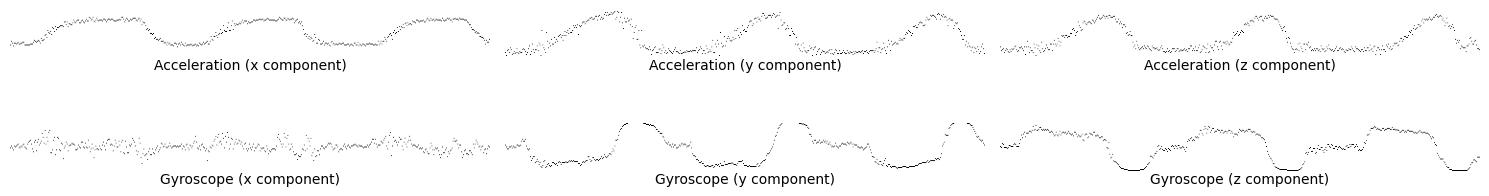

In [17]:
plot_sample_1(train_images_tf1)

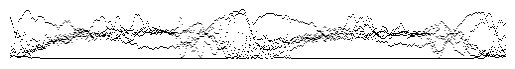

In [18]:
plot_sample_2(train_images_tf2)

### **Train Networks**

The architectures the authors tested are shown in the below diagram taken from their paper. We will test the middle architectures, staying faithful to the design, but dropping the (green) fully connected layers and adding a GlobalMaxPooling layer.

<figure>
    <img src="../documentation/reimaginingpricetrends.png" alt="Alt text" width="500" />
    <figcaption style="text-align: center;">Figure 1: Diagram of CNN models</figcaption>
</figure>

In [20]:
model_arc1_1 = Sequential([
    Conv2D(64, (5, 3), activation=None, input_shape=(50, 500, 6)),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    Conv2D(128, (5, 3), activation=None),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    Conv2D(256, (5, 3), activation=None),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    GlobalMaxPool2D(),
    Flatten(),
    #Dense(46080), # This is too computationally expensive to include
    Dense(31),
])

model_arc1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 498, 64)       5824      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 46, 498, 64)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 498, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 496, 128)      123008    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 19, 496, 128)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 496, 128)       0         
 g2D)                                                 

In [21]:
model_arc1_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_arc1_1.fit(train_ds1, validation_data=val_ds1, epochs=10)

Epoch 1/10
190/190 [==============================] - 11s 20ms/step - loss: nan - accuracy: 0.0452 - val_loss: nan - val_accuracy: 0.0333
Epoch 2/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 3/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 4/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 5/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 6/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 7/10
190/190 [==============================] - 2s 12ms/step - loss: nan - accuracy: 0.0402 - val_loss: nan - val_accuracy: 0.0333
Epoch 8/10
190/190 [====================

In [19]:
model_arc1_2 = Sequential([
    Conv2D(64, (5, 3), activation=None, input_shape=(50, 500, 1)),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    Conv2D(128, (5, 3), activation=None),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    Conv2D(256, (5, 3), activation=None),
    LeakyReLU(),
    MaxPool2D((2, 1)),
    GlobalMaxPool2D(),
    Flatten(),
    #Dense(46080), # This is too computationally expensive to include
    Dense(31),
])

model_arc1_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 498, 64)       1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 46, 498, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 498, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 496, 128)      123008    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 19, 496, 128)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 496, 128)       0         
 g2D)                                                   

In [20]:
model_arc1_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model_arc1_2.fit(train_ds2, validation_data=val_ds2, epochs=10)

Epoch 1/10
190/190 [==============================] - 10s 17ms/step - loss: nan - accuracy: 0.0343 - val_loss: nan - val_accuracy: 0.0383
Epoch 2/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 3/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 4/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 5/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 6/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 7/10
190/190 [==============================] - 2s 10ms/step - loss: nan - accuracy: 0.0346 - val_loss: nan - val_accuracy: 0.0383
Epoch 8/10
190/190 [====================

This method performed on par with or worse than a random guess. There is lots of redundancy in this input data, where the level of the time series is inferred by the vertical position of the only pixel per column that is white (multi-channeled) or one of $\leq$ 6 pixels per column that are white (single channelled).

## **References**

[1] Jiang, Jingwen, Bryan T. Kelly and Dacheng Xiu. “(Re-)Imag(in)ing Price Trends.” Capital Markets: Asset Pricing & Valuation eJournal (2020): n. pag.